In [1]:
#pip install keras

In [2]:
#pip install pandas_datareader

In [97]:
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [98]:
#prikazi floatove normalno, a ne u scientific formatu
pd.options.display.float_format = '{:.2f}'.format

In [99]:
df0 = pd.read_excel('trendBTC1.xlsx',  header=0)

df0

,Unnamed: 0,Row Labels,Count of Posts,Sum of Voted Score,BTC open value,BTC close value,Promena,Znak,Prethodni Trend,Znak Prethodni,Buduca Promena,Znak Buduca
0,0,2020-12-01 00:00:00,1,1.26,19695.87,19565.47,-130.40,-1,0.00,0,-0.72,-1
1,1,2020-12-01 01:00:00,2,0.73,19565.47,19605.75,40.28,1,0.00,0,-5.38,-1
2,2,2020-12-01 02:00:00,5,-0.10,19605.75,19680.95,75.20,1,0.00,0,-4.68,-1
3,3,2020-12-01 03:00:00,5,1.41,19680.96,19419.74,-261.22,-1,0.00,0,-0.69,-1
4,4,2020-12-01 04:00:00,4,2.73,19419.73,19354.31,-65.42,-1,0.00,0,-0.47,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
2694,2694,2021-04-30 19:00:00,3,0.00,56857.48,57007.38,149.90,1,7.85,1,0.00,0
2695,2695,2021-04-30 20:00:00,5,0.18,57007.38,56757.34,-250.04,-1,7.13,1,0.00,0
2696,2696,2021-04-30 21:00:00,3,0.93,56757.34,56976.53,219.19,1,6.84,1,0.00,0
2697,2697,2021-04-30 22:00:00,4,3.78,56976.53,57119.75,143.22,1,6.99,1,0.00,0


In [100]:
kolone = [ 'Row Labels', 'Sum of Voted Score', 'BTC close value']
df = df0[kolone]

# drop last 2 rows
df.drop(df.tail(2).index,inplace=True) 

#menjamo index 
df = df.set_index(pd.DatetimeIndex(df['Row Labels'].values))
del df['Row Labels']
df

C:\Users\hesh\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Sum of Voted Score,BTC close value
2020-12-01 00:00:00,1.26,19565.47
2020-12-01 01:00:00,0.73,19605.75
2020-12-01 02:00:00,-0.10,19680.95
2020-12-01 03:00:00,1.41,19419.74
2020-12-01 04:00:00,2.73,19354.31
...,...,...
2021-04-30 17:00:00,1.40,56546.79
2021-04-30 18:00:00,1.88,56857.47
2021-04-30 19:00:00,0.00,57007.38
2021-04-30 20:00:00,0.18,56757.34


In [101]:
#pravimo novi df samo sa close kolonom
#data = df.filter(['Sum of Voted Score', 'BTC close value'])

#konvertujemo df u numpy array
dataset = df.values

#broj redova na kojem cemo trenirati model
#koristimo 86% jer fale neki podaci u aprilu
training_data_len = math.ceil(len(dataset) * .86)
training_data_len 

2320

In [102]:
#skaliramo podatke (dobra praksa koja cesto olaksava treniranje NN)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# for i in range(0,25):
#     print(scaled_data[i])

<function matplotlib.pyplot.show(close=None, block=None)>

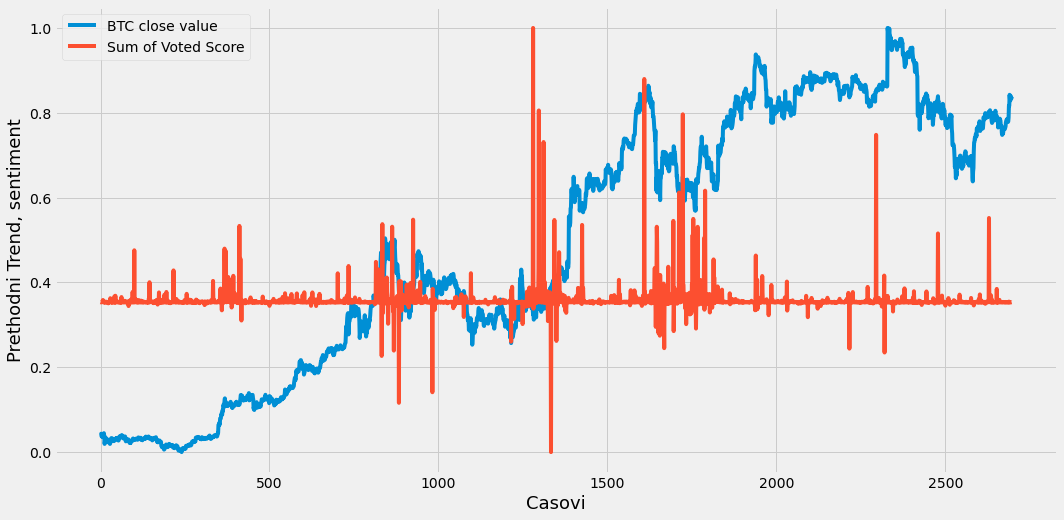

In [103]:
scaled_data_df = pd.DataFrame(scaled_data, columns = ['Sum of Voted Score', 'BTC close value'])
scaled_data_df

plt.figure(figsize=(16,8))
plt.plot(scaled_data_df['BTC close value'], label='BTC close value')
plt.plot(scaled_data_df['Sum of Voted Score'], label='Sum of Voted Score')
#plt.plot(scaled_data_df['Buduca Promena'].head(300), label='Buduca Promena')
plt.xlabel('Casovi',fontsize=18)
plt.ylabel('Prethodni Trend, sentiment', fontsize=18)
plt.legend()
plt.show

In [173]:
#pravimo data set za treniranje
#pravimo skaliran data set za treniranje
train_data = scaled_data[0:training_data_len, :]
#delimo podatke na x_train i y_train data set
x_train = []
y_train = []

# kolone redom: Sum of Voted Score, BTC close value, Prethodni Trend, Buduca Promena

# ovo je kod ako zelimo da uzimamo samo po jednu vrednost iz 'sentiment' i 'prethodni trend':
# for i in range(24, len(train_data)):
#     x_train.append(train_data[i, 0:2])
#     y_train.append(train_data[i, 2])    
# x_train
# print(y_train)
# print()

# ovo je kod ako zelimo da uzimamo poslednjih 24 closea i 24 sentimenta (vremenske serije):
for i in range(0, len(train_data)-24):
    # -1 !!!!!!!!!!!!!
    x_train.append(train_data[i:i+24, 0:2])
    y_train.append(train_data[i+24, 1])
    if i<=25:
        print(x_train)
        print(y_train)
        print()


[array([[0.35346157, 0.04086466],
       [0.35325825, 0.04172297],
       [0.35293867, 0.04332537],
       [0.35352029, 0.03775936],
       [0.35402899, 0.03636515],
       [0.35370043, 0.0391229 ],
       [0.35395225, 0.03602485],
       [0.35851853, 0.03980264],
       [0.35317292, 0.03876619],
       [0.35308274, 0.04085464],
       [0.35666138, 0.0445732 ],
       [0.35297819, 0.03787145],
       [0.35363506, 0.01925525],
       [0.35229326, 0.02369552],
       [0.35254095, 0.03489486],
       [0.35400148, 0.03442735],
       [0.35348084, 0.03006826],
       [0.35297819, 0.03005974],
       [0.35460557, 0.02324996],
       [0.35303655, 0.03030244],
       [0.3532444 , 0.02933354],
       [0.3532297 , 0.02963335],
       [0.35275943, 0.02657792],
       [0.35069443, 0.02380696]])]
[0.025331587453960247]

[array([[0.35346157, 0.04086466],
       [0.35325825, 0.04172297],
       [0.35293867, 0.04332537],
       [0.35352029, 0.03775936],
       [0.35402899, 0.03636515],
       [0.35370

In [174]:
#Convert the x_train and y_Train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2296, 24, 2)

In [175]:
#LSTM neuronska mreza prima 3d podatke (broj slucajeva, broj timestepova, broj feature(atribute koje koristimo u predikciji, kod nas su to sentiment i prethodni trend))
#2D podatke prebacujemo u 3D
#np.reashape prima niz i novu strukturu
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
x_train.shape

(2296, 24, 2)

In [207]:
# LSTM model
model=Sequential()

#dodajemo sloj od 50 neurona, vraca
model.add(LSTM(200, return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(150, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))

In [208]:
#Kompajliranje modela
model.compile(optimizer='adam', loss='mean_squared_error')

In [209]:
#Treniranje modela
model.fit(x_train,y_train, batch_size=10, epochs=10)

Epoch 1/10
230/230 [==============================] - 10s 28ms/step - loss: 0.0128
Epoch 2/10
230/230 [==============================] - 6s 28ms/step - loss: 5.3021e-04
Epoch 3/10
230/230 [==============================] - 6s 28ms/step - loss: 5.1651e-04
Epoch 4/10
230/230 [==============================] - 7s 28ms/step - loss: 4.1045e-04
Epoch 5/10
230/230 [==============================] - 6s 25ms/step - loss: 4.3590e-04
Epoch 6/10
230/230 [==============================] - 6s 28ms/step - loss: 3.6917e-04
Epoch 7/10
230/230 [==============================] - 6s 28ms/step - loss: 3.4618e-04
Epoch 8/10
230/230 [==============================] - 8s 36ms/step - loss: 2.6899e-04
Epoch 9/10
230/230 [==============================] - 7s 32ms/step - loss: 2.5204e-04
Epoch 10/10
230/230 [==============================] - 6s 28ms/step - loss: 2.7062e-04


In [210]:
# pravimo test data set
# pravimo novi niz koji sadrzi skalirane vrednosti od dana 2160 do 2699
test_data = scaled_data[training_data_len - 24: , :]


#pravimo data setove x_test i y_test
x_test = []
# +104 dana jer nam toliko fali podataka u aprilu
y_test = dataset[training_data_len+104: , 1 ]

# dodajemo 104 dana jer u aprilu fali toliko
for i in range(24+104, len(test_data)):
    x_test.append(test_data[i-24:i, 0:2])
    
y_test.shape


(273,)

In [211]:
#konvertujemo podatke u np array kako bi mogli da ih koristimo u LSTM modelu
x_test = np.array(x_test)
x_test.shape

(273, 24, 2)

In [212]:
#Reshape                     broj sekvenci,duzina sekvence(24),broj featura
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))
x_test.shape

(273, 24, 2)

In [213]:
# predikcija!!!
predictions = model.predict(x_test)

#scaler je 2D(sent, cena), a meni treba 1D(cena), zato pravim novi scaler_novi koji ce imati iste parametre kao scaler
scaler_novi = MinMaxScaler()
scaler_novi.min_, scaler_novi.scale_ = scaler.min_[1], scaler.scale_[1]

# odskaliranje 
predictions = scaler_novi.inverse_transform(predictions)
# matricu konvertujemo u niz
predictions = predictions.flatten()

#na grafu se vidi da predikcije uvek kaskaju za nekih 1500 za stvarnim vrednostima, zato pomeramo
#predictions_pomeren = predictions

In [214]:
y_test.shape

(273,)

In [215]:
# mean squared error (MSE) 
mse = np.sqrt(np.mean(predictions - y_test) **2)
mse


224.12136790293047

In [216]:
predictions

array([55475.785, 54796.043, 54745.977, 54986.15 , 55245.316, 55554.195,
       55773.574, 55794.816, 55840.367, 55951.402, 56197.992, 56437.266,
       56669.664, 56674.426, 56817.156, 56934.418, 57041.1  , 57154.758,
       57197.254, 57039.492, 57160.75 , 57090.26 , 56937.074, 57012.96 ,
       56920.9  , 56856.297, 56395.984, 55664.855, 55174.895, 55116.832,
       55321.902, 55673.03 , 56044.36 , 56352.29 , 56450.62 , 56317.004,
       55786.785, 55343.824, 55233.977, 55157.258, 54738.344, 54543.777,
       54785.734, 54976.816, 55462.44 , 56021.67 , 56244.77 , 56477.965,
       56263.88 , 55969.758, 55892.17 , 55928.05 , 56123.145, 56419.02 ,
       56708.273, 56785.867, 56808.81 , 56786.395, 56592.145, 56107.75 ,
       55750.062, 55555.36 , 55445.703, 55462.86 , 55572.137, 55453.64 ,
       55178.363, 55243.027, 55462.97 , 55885.867, 56226.434, 56283.453,
       56151.453, 55909.53 , 55762.707, 55504.516, 55216.598, 54761.133,
       54320.504, 54138.254, 54046.32 , 53978.062, 

<ipython-input-217-d87be33379bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


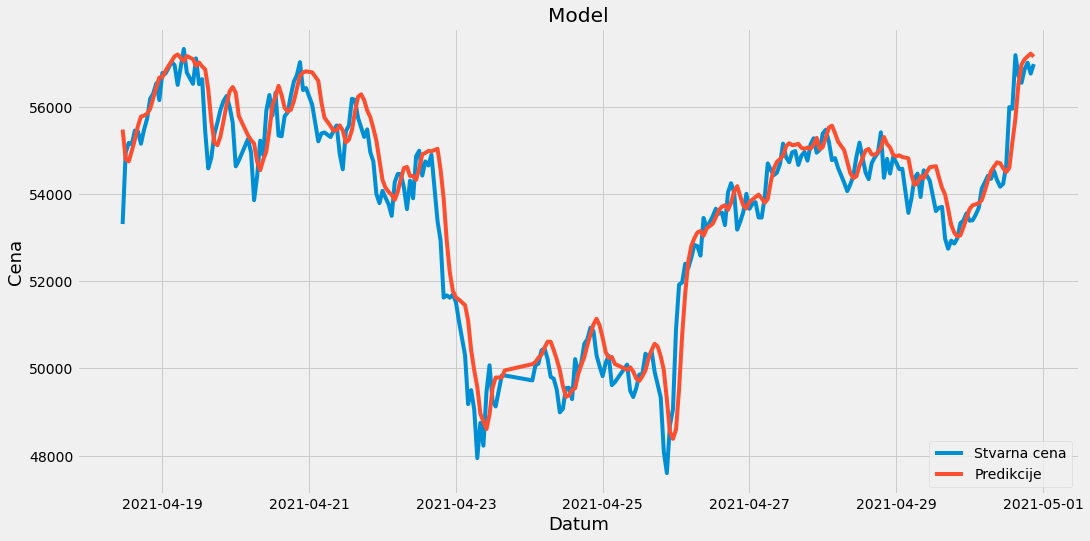

In [217]:
# podaci za graf
train = df[2400:training_data_len]
# dodajemo 104 dana jer toliko fali u aprilu
valid = df[training_data_len+104:]
valid['Predictions'] = predictions

# visualizacija
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Cena', fontsize=18)
#plt.plot(train['BTC close value'])
plt.plot(valid[['BTC close value', 'Predictions']])
plt.legend(['Stvarna cena','Predikcije'], loc='lower right')
plt.show()

In [218]:
valid

,Sum of Voted Score,BTC close value,Predictions
2021-04-18 11:00:00,0.53,53308.92,55475.79
2021-04-18 12:00:00,-1.32,54947.24,54796.04
2021-04-18 13:00:00,0.73,55169.06,54745.98
2021-04-18 14:00:00,6.39,55135.56,54986.15
2021-04-18 15:00:00,2.84,55452.45,55245.32
...,...,...,...
2021-04-30 17:00:00,1.40,56546.79,56965.44
2021-04-30 18:00:00,1.88,56857.47,57085.07
2021-04-30 19:00:00,0.00,57007.38,57154.12
2021-04-30 20:00:00,0.18,56757.34,57215.51
